In [1]:
# following libraries to perform different operations on the data
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, FuncFormatter
import seaborn as sns
import scipy.stats as stats
import random

import requests 
import zipfile 
import io 
import pandas as pd
import datetime as dt
from datetime import date


%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


import plotly.express as px
import datetime as dt
from datetime import date
from scipy.stats import anderson
from scipy.stats import spearmanr
import csv

import matplotlib.image as mpimg
from datetime import date, timedelta
import datetime


from matplotlib.pyplot import show

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt


pd.options.display.max_columns = None

[Base de Datos](#Base-de-Datos)

[Preprocesamientos](#Preprocesamientos)

[XGBoost](#XGBoost)

[SHAP](#SHAP)



## Base de Datos
Descarga de datos:  <a url='http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip' target="_blank">http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip</a>

En caso de ser necesario copiar la URL y pegar en el navegador manualmente, la descarga debería comenzar de manera instántanea.

In [ ]:
#carga manual de datos en caso de ser necesaria. 
Datos = pd.read_csv('220521COVID19MEXICO.csv',encoding ='unicode_escape',header=0, index_col=0, parse_dates=True, squeeze=True, error_bad_lines=False)

In [ ]:
Datos.shape

In [ ]:
DatosTest=Datos.copy()

In [ ]:
DatosTest15 = DatosTest[DatosTest.FECHA_SINTOMAS < '2022-04-15']  
DatosTest15

In [ ]:
DatosTest15['HOSPITALIZADO'].value_counts()

## Preprocesamientos
Asegurate de tener una carpeta 'csv' en la misma ubicación de esta notebook. También se requiere tener el archivo 'idh.csv' 

In [11]:


#genera la variable cve_ent, para juntar con otros df, generalmente debe hacerse primero para evitar posibles inconvenientes. 
def first(Datos):
    #ENTRADAS: 
    #SALIDAS: 
    
    allcve=Datos.copy()
    allcve["cve_ent"] = allcve["ENTIDAD_RES"].astype(str).str.zfill(2) +allcve["MUNICIPIO_RES"].astype(str).str.zfill(3)
    return allcve

def fecha(Datos):
    #ENTRADAS: 
    #SALIDAS: 
    
    Datos['FECHA_DEF'] = Datos['FECHA_DEF'].replace(['9999-99-99'],'2000-01-01')
    Datos['FECHA_INGRESO'] = pd.to_datetime(Datos['FECHA_INGRESO'])
    Datos['FECHA_SINTOMAS'] = pd.to_datetime(Datos['FECHA_SINTOMAS'])
    Datos['FECHA_DEF'] = pd.to_datetime(Datos['FECHA_DEF'])
    Datos['defuncion'] = np.where(Datos['FECHA_DEF']== '2000-01-01', 0, 1)
    return Datos


    
def positiveOnly(df):
    #ENTRADAS: 
    #SALIDAS: 
    
    df['confirmado'] = np.where(df['CLASIFICACION_FINAL']< 4, 1, 2)
    return(df[(df.confirmado == 1) ])

#IMPORTANTE: función que resume lo necesario para trabajar el df con solo positivos y que sea funcional. ALTAMENTE RECOMENDABLE PARA UN NUEVO EXPERIMENTO INICIAR CON ESTO.
def preproceso1(df):
    #ENTRADAS: 
    #SALIDAS: 
    
    a=first(df)
    b=fecha(a)
    return positiveOnly(b)


# eleiminar todos los 97+
def onezero(df):
    #ENTRADAS: 
    #SALIDAS: 
    
    no98 = df[df.NEUMONIA < 97]
    no98 = no98[no98.DIABETES < 97]
    no98 = no98[no98.EPOC < 97]
    no98 = no98[no98.ASMA < 97]
    no98 = no98[no98.INMUNOSUPRESION < 97]
    no98 = no98[no98.HIPERTENSION < 97]
    no98 = no98[no98.CARDIOVASCULAR < 97]
    no98 = no98[no98.OBESIDAD < 97]
    no98 = no98[no98.RENAL_CRONICA < 97]
    no98 = no98[no98.TABAQUISMO < 97]
    
    #no98 = no98[no98.INTUBADO < 97]
    return no98

#cambiar negativos a 0
def negtozero(no98): #post seleccion
    #ENTRADAS:
    #SALIDAS:
    
    for col in no98:
        if col!='EDAD' and col!='clave':
            no98[col] = np.where(no98[col] == 2, 0, no98[col])
    return no98
        

#se intercambian valores 1-2
def rename(df):
    #ENTRADAS: Dataframe de datos generales
    #SALIDAS: Mismo dataframe pero con la var. TIPO_PACIENTE renombrada a HOSPITALIZADO
    #y en formato tipo one hot encoding. Renombra var. INMUSUPR a INMUNOSUPRESION (se agrega).
    
    
    df['HOSPITALIZADO'] = np.where(df['TIPO_PACIENTE'] == 1, 0, 1)
    df['HOSPITALIZADO'] = np.where(df['TIPO_PACIENTE'] == 2, 1, 0)
    
    df['INMUNOSUPRESION'] = np.where(df['INMUSUPR'] == 1, 1, 0)
    
    return df

def intubado(df):
    #ENTRADAS:
    #SALIDAS:
    
    
    df['INTUBADO'] = np.where(df['INTUBADO'] != 1, 0, 1)
    return df


def unknowtozero(df):
    #ENTRADAS:
    #SALIDAS:
    
    for col in df:
        if col!='EDAD' and col!='clave' and col!= 'cve_ent':
            df[col] = np.where(df[col] > 2, 0, df[col])
    return df

#ELIMINA 1, 7, 13, 14 Y 99 DE SECTOR y crea un hot encoding para las demás variables. Además, combina SEDENA Y SEMAR en una misma variable (H_MILITAR)
#Así como también, el DIF, IMSS Bienestar, Pemex y estatal en la variable H_OTRO.  
def presector(df): 
    #ENTRADAS: Conjunto de datos general.
    #SALIDAS: Mismo conjunto pero con variables referentes a las unidades médicas más importantes de la variable SECTOR.
    
    df=df[df.SECTOR != 1]
    df=df[df.SECTOR != 7]
    df=df[df.SECTOR != 13]
    df=df[df.SECTOR != 14]
    df=df[df.SECTOR != 99]
    df['H_DIF'] = np.where(df['SECTOR'] == 2, 1,0)
    df['H_ESTATAL'] = np.where(df['SECTOR'] == 3, 1,0)
    df['H_IMSS'] = np.where(df['SECTOR'] == 4, 1,0)
    df['H_IMSS_BIEN'] = np.where(df['SECTOR'] == 5, 1,0)
    df['H_ISSSTE'] = np.where(df['SECTOR'] == 6, 1,0)
    df['H_PEMEX'] = np.where(df['SECTOR'] == 8, 1,0)
    df['H_PRIVADA'] = np.where(df['SECTOR'] == 9, 1,0)
    df['H_SEDENA'] = np.where(df['SECTOR'] == 10, 1,0)
    df['H_SEMAR'] = np.where(df['SECTOR'] == 11, 1,0)
    df['H_SSA'] = np.where(df['SECTOR'] == 12, 1,0)
    
    df['H_MILITAR'] = np.where((df['H_SEDENA'] == 1) | (df['H_SEMAR'] == 1), 1,0)
    df['H_OTRO'] = np.where((df['H_DIF'] == 1) | (df['H_IMSS_BIEN'] == 1) | (df['H_PEMEX'] == 1) | (df['H_ESTATAL'] == 1), 1,0)
    
    return df

#Juntar el dataframe de datos general con el df del CONEVAL 2015 para obtener el valor de IDH por municipio.
def add_idh(df, filename): #idh.csv
    #ENTRADAS: Conjunto de datos general y ubicación del archivo csv con datos del IDH.
    #SALIDAS: Conjunto de datos general combinado con el conjunto de datos del CONEVAL 2015.
    
    df_idh=pd.read_csv(filename,encoding ='unicode_escape',header=0, parse_dates=True, squeeze=True, error_bad_lines=False)
    df_idh["cve_ent"] = df_idh["ce"].astype(str).str.zfill(2) +df_idh["cm"].astype(str).str.zfill(3)
    
    df2 = pd.merge(df, df_idh, on=["cve_ent"])
    return df2

    

#generar variables para IDH
def idh_inter(df):
    #ENTRADAS: conjunto de datos general.
    #SALIDAS: Mismo conjunto pero con variables binarias para intervalos de IDH agregadas. 
    
    df['IDH_MUY_ALTO'] = np.where(df['idh'] >= 0.85, 1,0)
    df['IDH_ALTO'] = np.where((df['idh'] < 0.85) & (df['idh'] >= 0.825), 1,0)
    df['IDH_MED_ALTO'] = np.where((df['idh'] < 0.825) & (df['idh'] >= 0.8), 1,0)
    df['IDH_MEDIO'] = np.where((df['idh'] < 0.8) & (df['idh'] >= 0.75), 1,0)
    df['IDH_BAJO'] = np.where((df['idh'] < 0.75) & (df['idh'] >= 0.7), 1,0)
    df['IDH_MUY_BAJO'] = np.where(df['idh'] < 0.7, 1,0)
    return df

#generar intervalos de edad
def age_inter(df): 
    #ENTRADAS: conjunto de datos general. 
    #SALIDAS: mismo conjuntode datos pero con las variables binarias para intervalos de edad.
    
    df['E_0a17'] = np.where(df['EDAD'] <= 17, 1,0)
    df['E_18a29'] = np.where((df['EDAD'] > 17) & (df['EDAD'] <= 29), 1,0)
    df['E_30a39'] = np.where((df['EDAD'] > 29) & (df['EDAD'] <= 39), 1,0)
    df['E_40a49'] = np.where((df['EDAD'] > 39) & (df['EDAD'] <= 49), 1,0)
    df['E_50a59'] = np.where((df['EDAD'] > 49) & (df['EDAD'] <= 59), 1,0)
    df['E_60'] = np.where(df['EDAD'] > 59, 1,0)
    return df

#Definir las oleadas en el conjunto de datos. 
def oleadas(df):
    #ENTRADAS: el conjunto de datos general. 
    #SALIDAS: el mismo conjunto pero con variables binarias agregadas para definir si el individuo pertenece a dicha oleada.  
    
    df['ola1'] = np.where((df['FECHA_SINTOMAS'] >= '2020-05-24') & (df['FECHA_SINTOMAS'] <= '2020-08-08'), 1,0) 
    df['ola2'] = np.where((df['FECHA_SINTOMAS'] >= '2020-11-22') & (df['FECHA_SINTOMAS'] <= '2021-02-13'), 1,0)
    df['ola3'] = np.where((df['FECHA_SINTOMAS'] >= '2021-05-30') & (df['FECHA_SINTOMAS'] <= '2021-10-23'), 1,0)
    df['ola4'] = np.where((df['FECHA_SINTOMAS'] >= '2021-12-19') & (df['FECHA_SINTOMAS'] <= '2022-04-15'), 1,0) #hasta 15 de abril
    df['all'] = np.where((df['FECHA_SINTOMAS'] >= '2020-05-24') & (df['FECHA_SINTOMAS'] <= '2022-04-15'), 1,0) #incluye todas las oleadas
    return df



#Función para contar el número de registros, registros positivos y  registros negativos en un conjunto de datos. 
def defcounter(df):
    #ENTTRADAS: Dataframe para contar.
    #SALIDAS: Ninguna, imprime el conteo. 
    
    neg, pos = np.bincount(df['defuncion'])
    total = neg + pos
    print('paramsearch Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} \n'.format(
        total, pos, 100 * pos / total, neg))


    

def remove_vars(df):
    #ENTRADAS:
    #SALIDAS:
    
    df.drop('INTUBADO',axis='columns', inplace=True)
    return df

# window size
window = 7
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

def pre_full(df):
    #ENTRADAS:
    #SALIDAS:
    
    df=preproceso1(df)
    df=rename(df)

    #df=ten_hospitalizar2(df)
    df=presector(df)
    df=add_idh(df, 'idh.csv')
    df=idh_inter(df)
    df=oleadas(df)
    dfull=age_inter(df)
    
    df=dfull[['defuncion','SEXO','INTUBADO',
               'NEUMONIA','DIABETES','HIPERTENSION','OBESIDAD','CARDIOVASCULAR','RENAL_CRONICA','TABAQUISMO','EPOC','ASMA','INMUNOSUPRESION',
               'E_0a17','E_18a29','E_30a39','E_40a49','E_50a59','E_60',               
               'ola1', 'ola2','ola3','ola4','all','H_IMSS','H_ISSSTE','H_PRIVADA','H_MILITAR','H_SSA','H_OTRO',
               'IDH_MUY_BAJO','IDH_BAJO','IDH_MEDIO','IDH_MED_ALTO','IDH_ALTO','IDH_MUY_ALTO',
               
          ]].copy()
    
    df=intubado(df)
    df=onezero(df)
    df=negtozero(df)
    
    #hacer un df para cada ola.
    dfola1 =  df[df['ola1']==1]
    dfola2 =  df[df['ola2']==1]
    dfola3 =  df[df['ola3']==1]
    dfola4 =  df[df['ola4']==1]
    df_all =  df[df['all']==1]
    
    #remover las variables para identificar la oleada la que pertenece el registro.
    dfola1.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola2.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola3.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola4.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    df_all.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    
    #guardar los df de olas en un csv cada uno.
    dfola1.to_csv('csv/dfola1.csv')
    dfola2.to_csv('csv/dfola2.csv')
    dfola3.to_csv('csv/dfola3.csv')
    dfola4.to_csv('csv/dfola4.csv')
    df_all.to_csv('csv/df_all.csv') 
    return dfull, df, dfola1, dfola2, dfola3, dfola4, df_all
    
def pre_full_h(df):
    #ENTRADAS:
    #SALIDAS:
    
    
    df=preproceso1(df) #consigue la clave que junta el estado y municipio. 
    df=rename(df) #Cambio el nombre de tipo paciente a hospitalizado y lo dejo en 1 0

   
    df =  df[df['HOSPITALIZADO']==1] #nos quedamos solo con hospitalizados
    df=presector(df) #generación de variables de hospitales
    df=add_idh(df, 'idh.csv') #agregar columnas sobre el IDH de la residencia del paciente
    df=idh_inter(df) #convertir los valores anteriores en variables por intervalos
    df=oleadas(df) #agregar columnas que deenoten a que ola pertenecen los pacientes. 
    dfull=age_inter(df) #variables para intervalos de edades
    
    df=dfull[['defuncion','SEXO','INTUBADO',
               'NEUMONIA','DIABETES','HIPERTENSION','OBESIDAD','CARDIOVASCULAR','RENAL_CRONICA','TABAQUISMO','EPOC','ASMA','INMUNOSUPRESION',
               'E_0a17','E_18a29','E_30a39','E_40a49','E_50a59','E_60',               
               'ola1', 'ola2','ola3','ola4','all','H_IMSS','H_ISSSTE','H_PRIVADA','H_MILITAR','H_SSA','H_OTRO',
               'IDH_MUY_BAJO','IDH_BAJO','IDH_MEDIO','IDH_MED_ALTO','IDH_ALTO','IDH_MUY_ALTO',
               
          ]].copy() #seleccionar las variables para experimentos
    
    df=intubado(df) #agregar columna de intubados (variable)
    df=onezero(df) #quitar los registros (pacientes/renglones) se desconoce algún valor de comorbilidad (97,98,99).   
    df=negtozero(df) #manejar todo en 1s (el paciente tiene esa característica) y 0s (el paciente no la tiene). 
    
    #hacer un df para cada ola.
    dfola1 =  df[df['ola1']==1]
    dfola2 =  df[df['ola2']==1]
    dfola3 =  df[df['ola3']==1]
    dfola4 =  df[df['ola4']==1]
    df_all =  df[df['all']==1]
    
    #remover las variables para identificar la oleada la que pertenece el registro.
    dfola1.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola2.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola3.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    dfola4.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    df_all.drop(['ola1', 'ola2', 'ola3','ola4','all'], axis=1, inplace=True)
    
    #guardar los df de olas en un csv cada uno.
    dfola1.to_csv('csv/h_dfola1.csv')
    dfola2.to_csv('csv/h_dfola2.csv')
    dfola3.to_csv('csv/h_dfola3.csv')
    dfola4.to_csv('csv/h_dfola4.csv') 
    df_all.to_csv('csv/h_df_all.csv')
    
    
    return dfull, df, dfola1, dfola2, dfola3, dfola4, df_all


    

## Visualización de Datos

In [ ]:
#pos=positiveOnly(Datos)
pos=preproceso1(DatosTest15)
positivos=rename(pos)

### Generar arreglos para graficar

In [10]:
df_hosp=positivos[['FECHA_SINTOMAS', 'INTUBADO', 'HOSPITALIZADO', 'defuncion']].copy()
df_hosp['FECHA_SINTOMAS'] =pd.to_datetime(df_hosp.FECHA_SINTOMAS)
df_hosp.sort_values(by='FECHA_SINTOMAS', inplace=True)

df_hosp

,FECHA_SINTOMAS,INTUBADO,HOSPITALIZADO,defuncion
FECHA_ACTUALIZACION,,,,
2022-05-21,2020-02-19,97,0,0
2022-05-21,2020-02-22,97,0,0
2022-05-21,2020-02-22,2,1,0
2022-05-21,2020-02-23,97,0,0
2022-05-21,2020-02-25,97,0,0
...,...,...,...,...
2022-05-21,2022-04-14,97,0,0
2022-05-21,2022-04-14,97,0,0
2022-05-21,2022-04-14,97,0,0


In [11]:
df_since23=df_hosp[df_hosp.FECHA_SINTOMAS >= '2020-02-23']
df_since23.head(20)

,FECHA_SINTOMAS,INTUBADO,HOSPITALIZADO,defuncion
FECHA_ACTUALIZACION,,,,
2022-05-21,2020-02-23,97,0,0
2022-05-21,2020-02-25,97,0,0
2022-05-21,2020-02-26,1,1,1
2022-05-21,2020-02-27,97,0,0
2022-05-21,2020-02-27,97,0,0
2022-05-21,2020-02-28,97,0,0
2022-05-21,2020-02-28,97,0,0
2022-05-21,2020-02-28,2,1,0
2022-05-21,2020-02-29,97,0,0


In [12]:

#solo falta agregar 0s en los días fantasma
intus=[]
hospis=[]
casos=[]
muertes=[]
actdate1=df_since23['FECHA_SINTOMAS'][0]
actdate2=df_since23['FECHA_SINTOMAS'][0]
intu=0
hosp=0
caso=0 
muerte=0

for index, paciente in df_since23.iterrows():
#for caso in df_hosp:
    actdate1=actdate2
    actdate2=paciente['FECHA_SINTOMAS'] 
    
    if (actdate1 != actdate2):
        intus.append(intu)
        hospis.append(hosp)
        casos.append(caso)
        muertes.append(muerte)
        intu=0
        hosp=0
        caso=0 
        muerte=0
        
    caso=caso+1
    if (paciente['INTUBADO']==1):
        intu=intu+1
    if (paciente['HOSPITALIZADO']==1):
        hosp=hosp+1
    if (paciente['defuncion']==1):
        muerte=muerte+1

    

In [13]:
print(len(muertes))
print(len(casos))
print(len(hospis))
print(len(intus))

780
780
780
780


In [14]:
# insert 0 at 1st index, representa el 24 de feb de 2020 que no hubo casos 
muertes.insert(1, 0) 
casos.insert(1, 0) 
hospis.insert(1, 0) 
intus.insert(1, 0) 

In [15]:
df_hosp['FECHA_SINTOMAS'].value_counts()

2022-01-10    79628
2022-01-17    68998
2022-01-11    60774
2022-01-12    58445
2022-01-18    57984
              ...  
2020-02-27        2
2020-02-23        1
2020-02-19        1
2020-02-26        1
2020-02-25        1
Name: FECHA_SINTOMAS, Length: 783, dtype: int64

## Gráficar Hospitalizados e Intubados.

In [16]:

casos_avg= moving_average(casos, window)
hospis_avg= moving_average(hospis, window)
intus_avg= moving_average(intus, window)
muertes_avg=moving_average(muertes, window)



In [5]:
casos=dataGraph[1]
casos_avg=dataGraph[4]
hospis_avg=dataGraph[5]
intus_avg=dataGraph[6]
muertes_avg=dataGraph[7]
adjusted=dataGraph[8]

In [17]:
adjusted=[]
for i in range(len(casos)):
    adjusted.append(i)

In [18]:
#23 dias de diferencia para empezar el 18 de marzo del 2020

In [19]:
adjusted[-1:] #debe ser 780

[780]

In [21]:
dataGraph=[muertes,casos,hospis,intus,casos_avg,hospis_avg,intus_avg,muertes_avg,adjusted]

In [22]:
%store dataGraph

Stored 'dataGraph' (list)


In [3]:
%store -r dataGraph

In [4]:
casos=dataGraph[1]
casos_avg=dataGraph[4]
hospis_avg=dataGraph[5]
intus_avg=dataGraph[6]
muertes_avg=dataGraph[7]
adjusted=dataGraph[8]

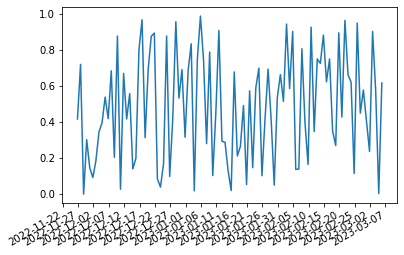

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

np.random.seed(1)

N = 100
y = np.random.rand(N)

now = dt.datetime.now()
then = now + dt.timedelta(days=100)
days = mdates.drange(now,then,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(days,y)
plt.gcf().autofmt_xdate()
plt.show()

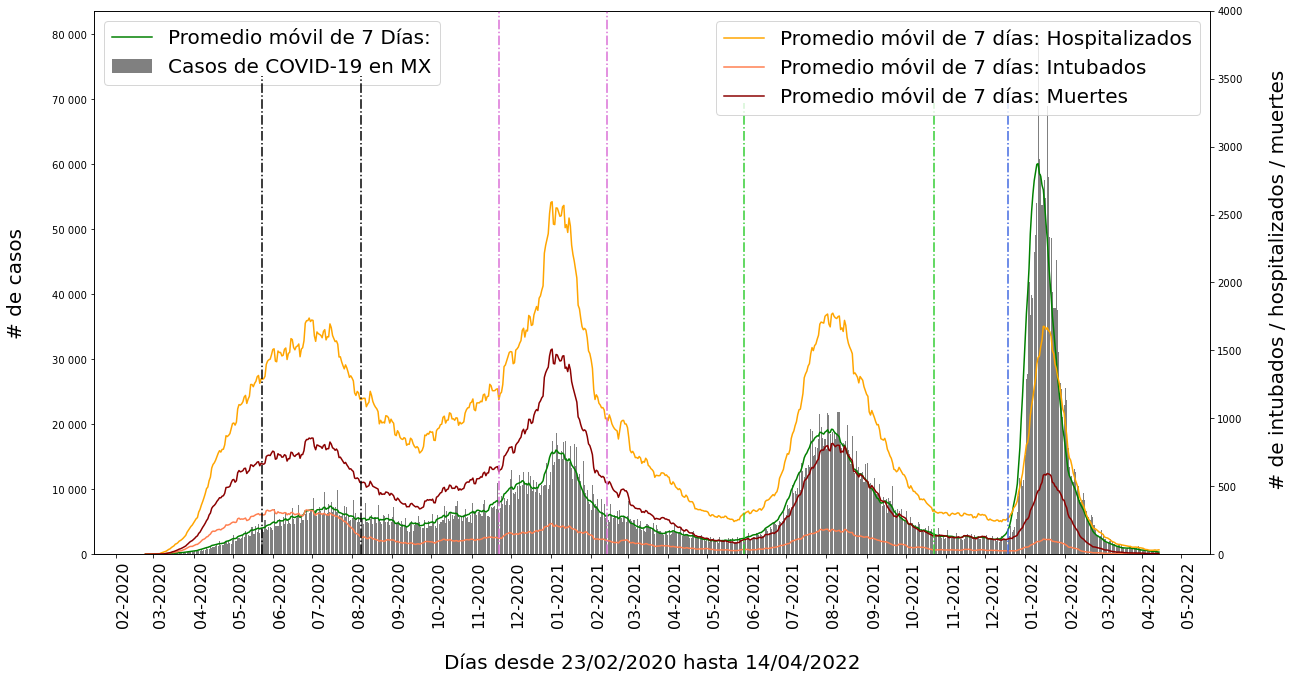

In [36]:
#TESTTTTTTTTTTTT
#Grafica spanish
x = []
d = dt.datetime(2020, 2, 23)
for i in range(781):
        d = d+dt.timedelta(days=1)
        x.append(d)

dias=x

plt.figure(figsize=(20,10))
#plt.bar(adjusted, casos_avg, color='gray',linestyle='dashed')

#plt.plot(adjusted, hospis, color='red', linestyle='dashed')

#plt.title('Casos, Intubados, Hospitalizados y Muertes en MX', size=24)
plt.xlabel('\nDías desde 23/02/2020 hasta 14/04/2022', size=20)

plt.ylabel('# de casos\n', size=20)

#{x:,.0f}
ax = plt.gca()
#ax.yaxis.set_major_formatter(StrMethodFormatter('{x:n}'))

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.get_xaxis().set_major_formatter(FuncFormatter(mdates.DateFormatter('%m-%Y')))
#ax.get_xaxis().set_major_locator(FuncFormatter(mdates.MonthLocator(interval=1)))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.tick_params(axis='x', labelrotation=45)

matplotlib.dates.MonthLocator(bymonth=None, bymonthday=1, interval=1, tz=None)

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{:,}'.format(int(x)).replace(",", " ")))


plt.bar(dias, casos, color='gray')
plt.plot(dias, casos_avg, color='green')

plt.xticks(dias, rotation=90, rotation_mode='anchor', ha='right', fontsize='16')

ax2 = plt.twinx()
ax2.set_ylim([0, 4000])


ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2.get_xaxis().set_major_formatter(FuncFormatter(mdates.DateFormatter('%m-%Y')))
#ax.get_xaxis().set_major_locator(FuncFormatter(mdates.MonthLocator(interval=1)))

ax2.get_xaxis().set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax2.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))


ax2.plot(dias, hospis_avg, color='orange')
ax2.plot(dias, intus_avg, color='coral')
ax2.plot(dias, muertes_avg, color='darkred')

ax2.set_ylabel('\n # de intubados / hospitalizados / muertes', size=20)



ax.legend(['Promedio móvil de 7 Días:', 'Casos de COVID-19 en MX'], prop={'size': 20},loc='upper left') #no sirve porque python es una basura
plt.legend(['Promedio móvil de 7 días: Hospitalizados', 'Promedio móvil de 7 días: Intubados', 'Promedio móvil de 7 días: Muertes'], prop={'size': 20}, loc='upper right')

'''
●	Primera ola (negro):	 SE22 del 2020 (2020/05/24) – SE32 del 2020 (2020/08/08) 
●	Segunda ola (rosa): 	 SE48 del 2020 (2020/11/22) – SE06 del 2021 (2021/02/13)
●	Tercera ola (verde):	 SE22 del 2021 (2021/05/30) – SE42 del 2021 (2021/10/23)
●	Cuarta ola (azul):	     SE51 del 2021 (2021/12/19) – SE15 (2022/04/15)

'''


plt.axvline(x = dt.datetime(2020, 5, 24, 0, 0), ymax =0.88,  color = 'black', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2020, 8, 8, 0, 0),ymax =0.88,  color = 'black', label = 'axvline - full height', linestyle='-.')


plt.axvline(x = dt.datetime(2020, 11, 22, 0, 0), color = 'orchid', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2021, 2, 13, 0, 0),  color = 'orchid', label = 'axvline - full height', linestyle='-.')

plt.axvline(x = dt.datetime(2021, 5, 30, 0, 0),  ymax =0.83, color = 'limegreen', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2021, 10, 23, 0, 0),  ymax =0.83, color = 'limegreen', label = 'axvline - full height', linestyle='-.')

plt.axvline(x = dt.datetime(2021, 12, 19, 0, 0),  ymax =0.83, color = 'royalblue', label = 'axvline - full height', linestyle='-.')

#plt.savefig('img/Grafica_SPA.png', dpi=300)


plt.show()

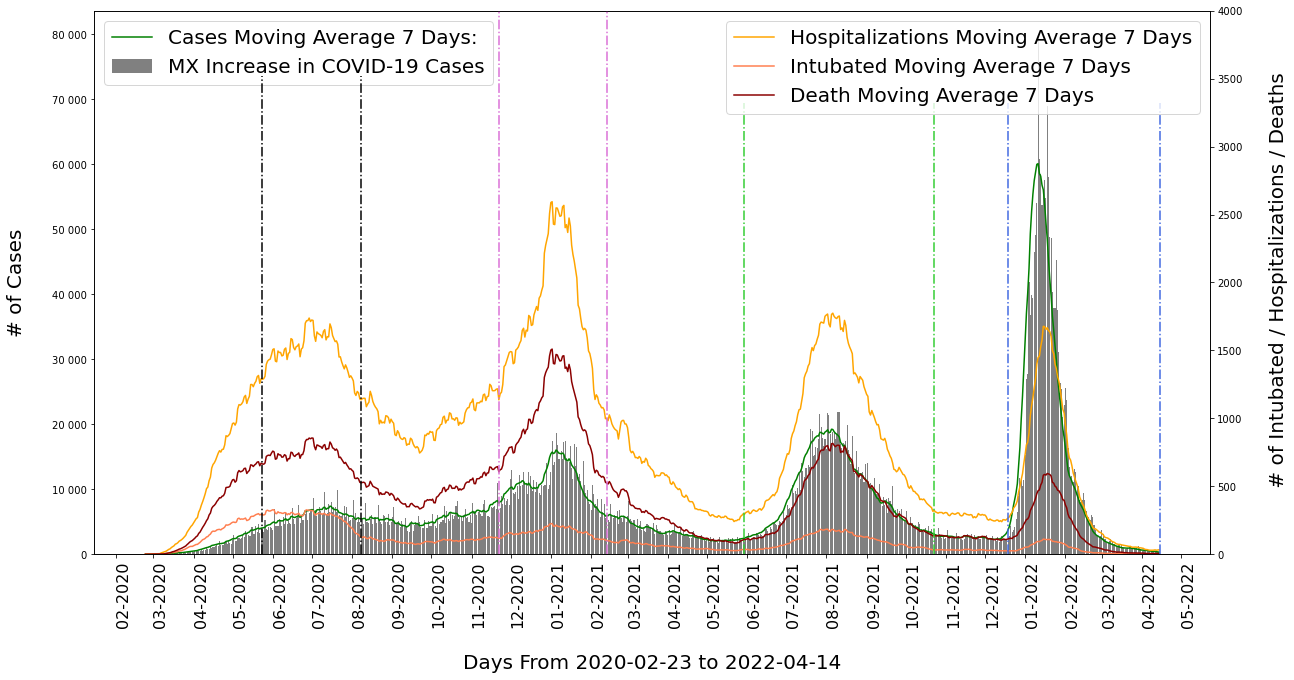

In [38]:
#English

window=7

x = []
d = dt.datetime(2020, 2, 23)
for i in range(781):
        d = d+dt.timedelta(days=1)
        x.append(d)

dias=x
#adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(20,10))
#plt.bar(adjusted, casos_avg, color='gray',linestyle='dashed')

#plt.plot(adjusted, hospis, color='red', linestyle='dashed')

#plt.title('Casos, Intubados, Hospitalizados y Muertes en MX', size=24)
plt.xlabel('\nDays From 2020-02-23 to 2022-04-14', size=20)
plt.ylabel('# of Cases\n', size=20)



#{x:,.0f}
ax = plt.gca()
#ax.yaxis.set_major_formatter(StrMethodFormatter('{x:n}'))



ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.get_xaxis().set_major_formatter(FuncFormatter(mdates.DateFormatter('%m-%Y')))
#ax.get_xaxis().set_major_locator(FuncFormatter(mdates.MonthLocator(interval=1)))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.tick_params(axis='x', labelrotation=45)

matplotlib.dates.MonthLocator(bymonth=None, bymonthday=1, interval=1, tz=None)

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))



ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{:,}'.format(int(x)).replace(",", " ")))
plt.legend(['Promedio Móvil de {} Días:'.format(window), 'Casos de COVID-19 en MX'], prop={'size': 20},loc='upper left')

#plt.legend(['Promedio Móvil de {} Días:'.format(window), 'Casos de COVID-19 en MX'], prop={'size': 20},loc='upper left')
#plt.legend(['Cases Moving Average {} Days'.format(window), 'MX Increase in COVID-19 Cases'], prop={'size': 20},loc='upper left')
#ax.legend(['Cases Moving Average 7 Days:', 'MX Increase in COVID-19 Cases'], prop={'size': 20},loc='upper left') #no sirve porque python es una basura

#ax2.get_xaxis().set_major_formatter(
#    plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#yt = np.arange(0, 84000, 4000)
#plt.yticks(yt)






#plt.plot(days,y)


plt.bar(dias, casos, color='gray')
plt.plot(dias, casos_avg, color='green')

plt.xticks(dias, rotation=90, rotation_mode='anchor', ha='right', fontsize='16')



ax2 = plt.twinx()
ax2.set_ylim([0, 4000])


ax2.xaxis_date()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax2.get_xaxis().set_major_formatter(FuncFormatter(mdates.DateFormatter('%m-%Y')))
#ax.get_xaxis().set_major_locator(FuncFormatter(mdates.MonthLocator(interval=1)))

ax2.get_xaxis().set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax2.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))



#ax2.figure(figsize=(16, 10))
#ax2.plot(adjusted_dates, world_daily_death, color='yellow')
#ax2.plot(adjusted, intus, color='orange', linestyle='dashed')
ax2.plot(dias, hospis_avg, color='orange')
ax2.plot(dias, intus_avg, color='coral')
ax2.plot(dias, muertes_avg, color='darkred')

#ax2.set_ylabel('\n # de intubados / hospitalizados / muertes', size=20)
ax2.set_ylabel('\n # of Intubated / Hospitalizations / Deaths', size=20)

#y_ticks = np.arange(0, 3501, 500)
#ax2.set_yticks(y_ticks)
#ax2.yticks(size=20)
#ax2.legend(['Intubated'.format(window)], prop={'size': 20}, loc='upper right')




#ax.legend(['Promedio móvil de 7 Días:', 'Casos de COVID-19 en MX'], prop={'size': 20},loc='upper left') #no sirve porque python es una basura


#plt.legend(['Promedio móvil de 7 días: Hospitalizados', 'Promedio móvil de 7 días: Intubados', 'Promedio móvil de 7 días: Muertes'], prop={'size': 20}, loc='upper right')
ax.legend(['Cases Moving Average 7 Days:', 'MX Increase in COVID-19 Cases'], prop={'size': 20},loc='upper left') #no sirve porque python es una basura
plt.legend(['Hospitalizations Moving Average 7 Days', 'Intubated Moving Average 7 Days', 'Death Moving Average 7 Days'], prop={'size': 20}, loc='upper right')



'''
●	Primera ola (negro):	 SE22 del 2020 (2020/05/24) – SE32 del 2020 (2020/08/08) 
●	Segunda ola (rosa): 	 SE48 del 2020 (2020/11/22) – SE06 del 2021 (2021/02/13)
●	Tercera ola (verde):	 SE22 del 2021 (2021/05/30) – SE42 del 2021 (2021/10/23)
●	Cuarta ola (azul):	     SE51 del 2021 (2021/12/19) – SE15 (2022/04/15)

'''

plt.axvline(x = dt.datetime(2020, 5, 24, 0, 0), ymax =0.88,  color = 'black', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2020, 8, 8, 0, 0),ymax =0.88,  color = 'black', label = 'axvline - full height', linestyle='-.')


plt.axvline(x = dt.datetime(2020, 11, 22, 0, 0), color = 'orchid', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2021, 2, 13, 0, 0),  color = 'orchid', label = 'axvline - full height', linestyle='-.')

plt.axvline(x = dt.datetime(2021, 5, 30, 0, 0),  ymax =0.83, color = 'limegreen', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2021, 10, 23, 0, 0),  ymax =0.83, color = 'limegreen', label = 'axvline - full height', linestyle='-.')

plt.axvline(x = dt.datetime(2021, 12, 19, 0, 0),  ymax =0.83, color = 'royalblue', label = 'axvline - full height', linestyle='-.')
plt.axvline(x = dt.datetime(2022, 4, 15, 0, 0),  ymax =0.83, color = 'royalblue', label = 'axvline - full height', linestyle='-.')
#plt.axvline(x = ,  ymax =0.87, color = 'b', label = 'axvline - full height', linestyle='--')
#620



plt.savefig('img/Grafica_ENG.png', dpi=300)


#plt.gcf().autofmt_xdate()
plt.show()